In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

In [2]:
trip_data_path = (r"C:\Users\kriti\kriti python\df_trips_202401.csv")
df = pd.read_csv(trip_data_path)

In [3]:
df['START_TIME'] = pd.to_datetime(df['START_TIME'], errors='coerce')
print("Earliest Date:", df['START_TIME'].min())
print("Latest Date:", df['START_TIME'].max())


Earliest Date: 2024-01-01 06:22:31
Latest Date: 2024-01-31 21:59:53


In [4]:
df["START_TIME"] = pd.to_datetime(df["START_TIME"])

# Filter rows where START_TIME is a Saturday (weekday = 5)
sat_df = df[df["START_TIME"].dt.weekday == 5].copy()

# Just double-check the shape and some dates
print("Filtered rows (Saturday):", len(sat_df))
print("Date range in Saturday data:", sat_df["START_TIME"].min(), "to", sat_df["START_TIME"].max())


Filtered rows (Saturday): 4080
Date range in Saturday data: 2024-01-06 07:09:09 to 2024-01-27 21:57:18


In [5]:
unique_sat_dates = sorted(sat_df['START_TIME'].dt.date.unique())
print("All Saturday dates in data:")
for d in unique_sat_dates:
    print(d)



All Saturday dates in data:
2024-01-06
2024-01-13
2024-01-20
2024-01-27


In [6]:
selected_sat_date = pd.to_datetime("2024-01-13") 
sat_single_day_df = sat_df[sat_df["START_TIME"].dt.date == selected_sat_date.date()].copy()

# Confirm the number of trips on that day
print("Trips on Jan 13, 2024:", len(sat_single_day_df))
sat_single_day_df.head(2)


Trips on Jan 13, 2024: 1843


,PROVIDER_ID,PROVIDER_NAME,DEVICE_ID,VEHICLE_ID,VEHICLE_TYPE,PROPULSION_TYPE,TRIP_ID,TRIP_DURATION,TRIP_DISTANCE,ROUTE,...,START_TIME_RAW,END_TIME_RAW,PUBLICATION_TIME_RAW,PARKING_VERIFICATION_URL,STANDARD_COST,ACTUAL_COST,CURRENCY,GEOM_POINTS,ID,RUN_DATE
18447,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,8577d1fe-e629-4d6a-a02e-0202a4158724,CAD3D,scooter,electric,957a7cf4-cae1-496d-97cc-123bdb162db2,349,1633,"{""type"":""FeatureCollection"",""features"":[{""type...",...,1705145049204,1705145398628,NaN,NaN,NaN,NaN,NaN,"{\n ""geometries"": [\n {\n ""coordinate...",3483424,NaN
18448,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,7b586eec-42d6-4e72-a774-0f8499bbc9af,1DR9G,scooter,electric,b25a4188-ead5-4ab5-97fc-d9d62a305f38,780,1458,"{""type"":""FeatureCollection"",""features"":[{""type...",...,1705149349818,1705150130777,NaN,NaN,NaN,NaN,NaN,"{\n ""geometries"": [\n {\n ""coordinate...",3483425,NaN


In [7]:
# Step: Convert meters to miles
sat_single_day_df["distance_miles"] = sat_single_day_df["TRIP_DISTANCE"] * 0.000621371

# Step: Define distance-based trip classes
def assign_trip_class(dist):
    if dist < 0.5:
        return 0
    elif 0.5 <= dist < 1:
        return 1
    elif 1 <= dist <= 2:
        return 2
    else:
        return 3

sat_single_day_df["trip_class"] = sat_single_day_df["distance_miles"].apply(assign_trip_class)

# Check the class distribution
sat_single_day_df["trip_class"].value_counts().sort_index()


0    685
1    637
2    357
3    164
Name: trip_class, dtype: int64

In [8]:
# Step: Calculate average values per class for Saturday
summary_df = sat_single_day_df.groupby("trip_class").agg(
    count=("trip_class", "size"),
    avg_distance_mile=("distance_miles", "mean"),
    avg_duration_min=("TRIP_DURATION", lambda x: x.mean() / 60),  # convert sec to min
    avg_speed_mph=("distance_miles", lambda d: d.sum() / (sat_single_day_df.loc[d.index, "TRIP_DURATION"].sum() / 3600))  # speed = total dist / total hours
).reset_index()

# Round values like in the slide
summary_df = summary_df.round({
    "avg_distance_mile": 2,
    "avg_duration_min": 2,
    "avg_speed_mph": 2
})

# Display result
summary_df


,trip_class,count,avg_distance_mile,avg_duration_min,avg_speed_mph
0,0,685,0.23,6.18,2.28
1,1,637,0.74,8.94,4.94
2,2,357,1.36,15.67,5.22
3,3,164,3.08,37.05,4.99


In [9]:
# Load LYNX Blue Line stations
stations_path = (r"C:\Users\kriti\LYNX_Blue_Line_Stations.geojson")
stations_gdf = gpd.read_file(stations_path)

# Load LYNX Blue Line route
route_path = (r"C:\Users\kriti\LYNX_Blue_Line_Route.geojson")
blue_line_route_gdf = gpd.read_file(route_path)

In [10]:
import json
from shapely.geometry import LineString
import geopandas as gpd

# Step 1: Filter Jan 13 data (Saturday)
jan13_df = sat_df[sat_df["START_TIME"].dt.date == pd.to_datetime("2024-01-13").date()].copy()

# Step 2: Convert meters to miles
jan13_df["distance_miles"] = jan13_df["TRIP_DISTANCE"] * 0.000621371

# Step 3: Assign trip class
def assign_trip_class(dist):
    if dist < 0.5:
        return 0
    elif 0.5 <= dist < 1:
        return 1
    elif 1 <= dist <= 2:
        return 2
    else:
        return 3

jan13_df["trip_class"] = jan13_df["distance_miles"].apply(assign_trip_class)

# Step 4: Convert ROUTE to LineString
def extract_linestring(route_str):
    try:
        route = json.loads(route_str)
        coords = [f["geometry"]["coordinates"] for f in route.get("features", []) if "geometry" in f]
        return LineString(coords) if len(coords) >= 2 else None
    except:
        return None

jan13_df["route_line"] = jan13_df["ROUTE"].apply(extract_linestring)
jan13_df = jan13_df[jan13_df["route_line"].notnull()].copy()

# Step 5: Convert to GeoDataFrame
gdf_routes_sat_all = gpd.GeoDataFrame(jan13_df, geometry="route_line", crs="EPSG:4326")


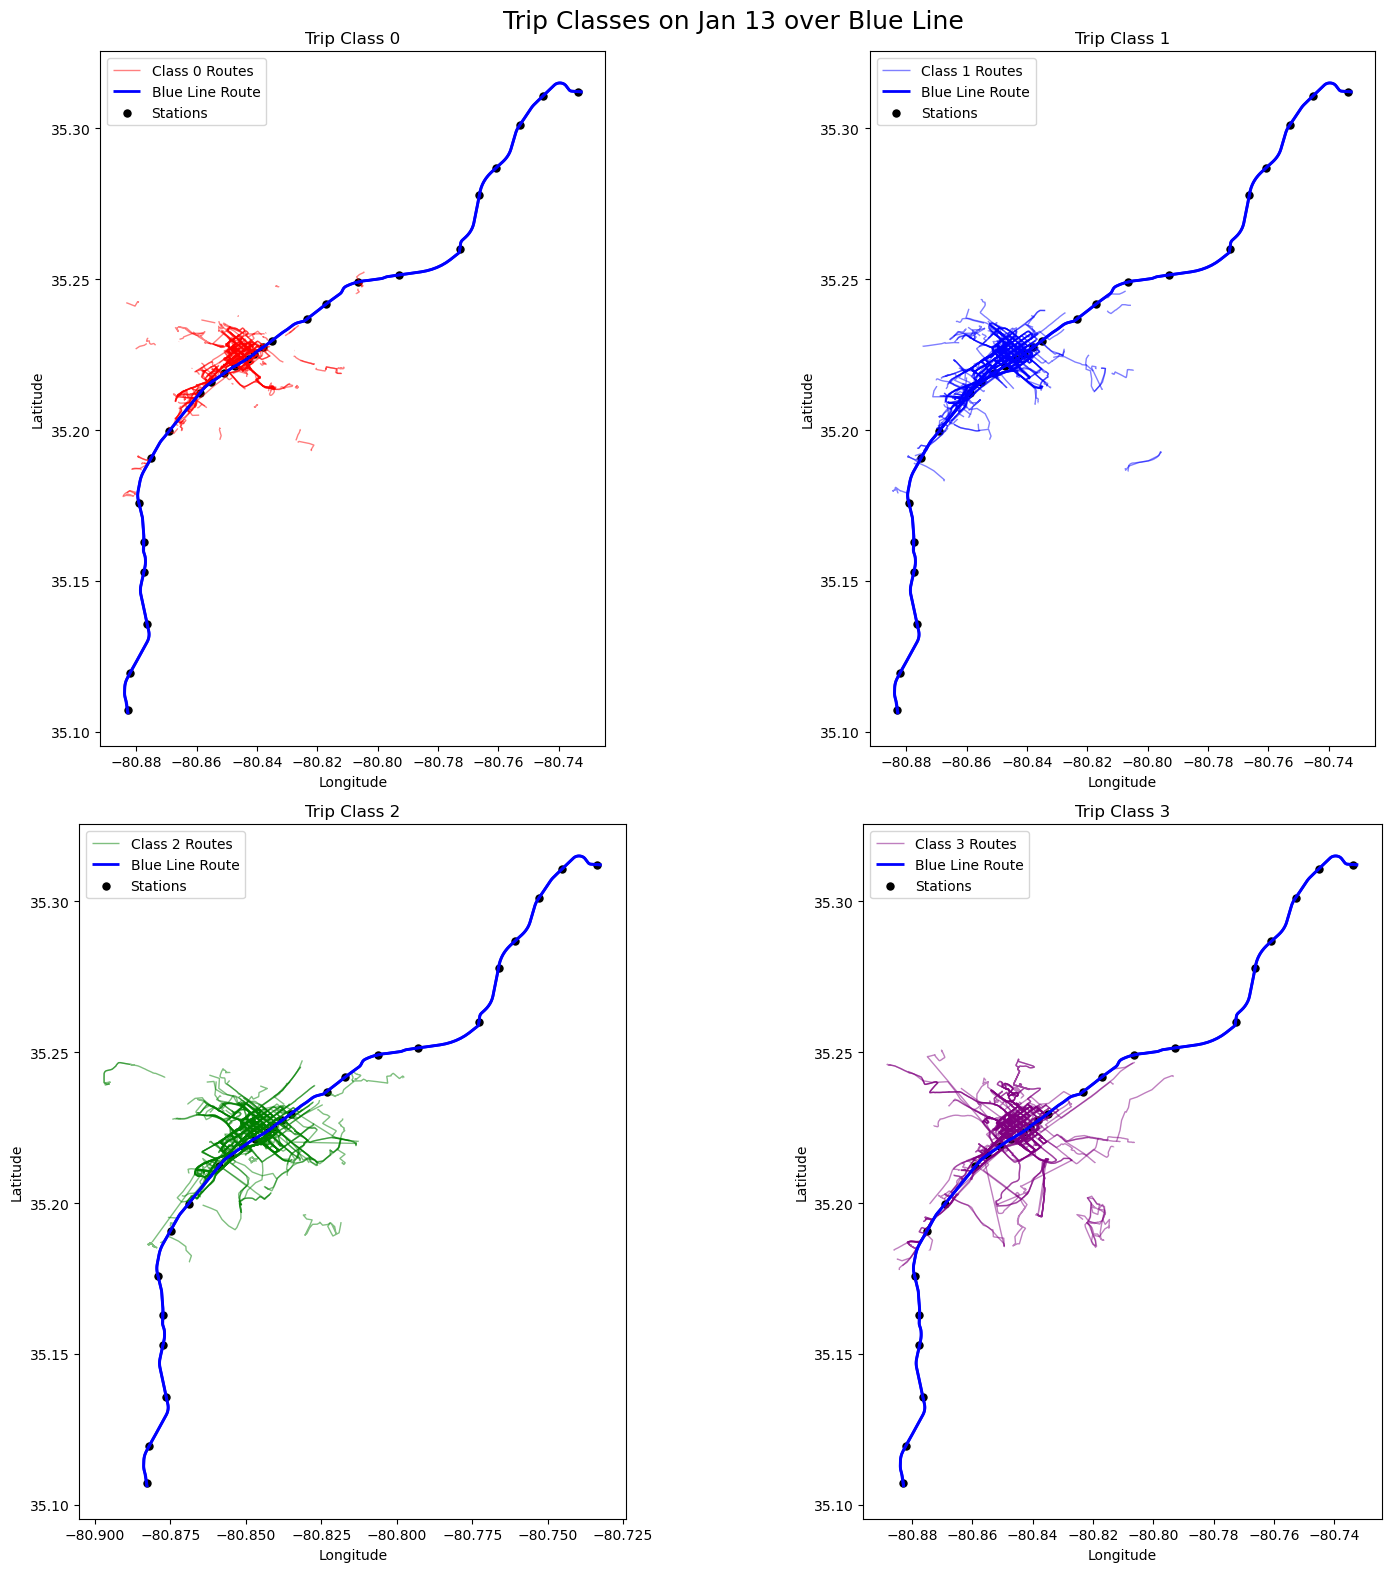

In [11]:
import matplotlib.pyplot as plt

# Color mapping per class
class_colors = {
    0: "red",
    1: "blue",
    2: "green",
    3: "purple"
}

# Plot each class in separate subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for i, (trip_class, ax) in enumerate(zip(sorted(class_colors.keys()), axes.flatten())):
    class_gdf = gdf_routes_sat_all[gdf_routes_sat_all["trip_class"] == trip_class]

    class_gdf.plot(ax=ax, color=class_colors[trip_class], linewidth=1, alpha=0.5, label=f"Class {trip_class} Routes")
    blue_line_route_gdf.plot(ax=ax, color="blue", linewidth=2, label="Blue Line Route")
    stations_gdf.plot(ax=ax, color="black", edgecolor="white", markersize=50, label="Stations")

    ax.set_title(f"Trip Class {trip_class}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    ax.set_aspect("equal")

plt.suptitle("Trip Classes on Jan 13 over Blue Line", fontsize=18)
plt.tight_layout()
plt.show()
